In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [3]:
#random low-pmi condition missing
categories_perturb = ['original', 'nouns', 'nouns-del50%', 'random-nouns', 'nounsverbs', 'nounsverbsadj', 'contentwords', 'functionwords', 'passageshuffle','random-sent']
categories_scrambled = ['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random-wl']#, random-lowpmi]

categories = [categories_perturb, categories_scrambled]
keys = ["perturb", "scrambled"]

categories_dict = dict(zip(keys, categories))

In [4]:
def get_score_dict(model_identifier,scr_perturb=None):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> list of scores across layers,
                                                    error --> list of associated errors}
    """
    score_dict = {}
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            if (f"-encoding-{scr_perturb}" in filename) or ("-encoding-scrambled-original" in filename):
                
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                
                if scr_perturb == "perturb":
                    condition = re.sub("perturb-","",condition)
                    condition = re.sub("scrambled-","",condition)
                    if condition == "randomsentenceshuffle":
                        condition = "random-sent"
                    if condition == "nouns-delete50percent":
                        condition = "nouns-del50%"
                    
                elif scr_perturb == "scrambled":
                    if not any(x in condition for x in ["1", "3", "5", "7"]):
                        condition = re.sub("scrambled-","",condition)
                    else:
                        condition = condition
                #print(condition)
                
                if not condition in score_dict:
                    score_dict[condition] = {}
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                #print(out['data'].layer) # sanity check which confirms order of layers is correct despite single-digit
                #names in e.g.g, gpt2, (i.e.: drop, encoder.h.0, encoder.h.1, ..., encoder.h.10, encoder.h.11)
                scores = [result[i][0] for i in range(len(result))]
                errors = [result[i][1] for i in range(len(result))]
                score_dict[condition]['score'] = scores
                score_dict[condition]['error'] = errors
    ordered_score_dict = reorder_df(score_dict, categories_dict, scr_perturb=scr_perturb)
    return ordered_score_dict

In [5]:
def reorder_df(dictionary, categories_dict, scr_perturb=None):
    desired_order_list = categories_dict[scr_perturb]
    reordered_dict = {k: dictionary[k] for k in desired_order_list}
    return reordered_dict

In [6]:
working_dir2 = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir2)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir2,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            if model_identifier == 'bert-large-uncased-whole-word-masking':
                shortened_names = ['.'.join(elm.split(".")[:-1]) for elm in layer_list if '.layer.' in elm]
                layer_list = [layer_list[0]] + shortened_names
                double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            #shorten layer names
            if model_identifier == 'lm_1b':
                layers = [layer.split('/')[1] for layer in layers]
            if 'albert' in model_identifier:
                layers = [re.sub('.albert_layer_groups.','.h.', layer) for layer in layers]
            return layers
            break

In [7]:
def get_layerplot(model_identifier,scr_perturb=None):
    #line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d")
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
        line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    layers = get_all_layers(model_identifier)
    score_dict = get_score_dict(model_identifier,scr_perturb=scr_perturb)
    print(score_dict['original'].keys())
        
    fig, ax = plt.subplots()
    
    x = np.array(layers)
    counter = 0
    for key,value in score_dict.items():
        ax.plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
        counter += 1

    conditions = list(score_dict.keys())

    ax.set_title(f'Layer neural score evolution across conditions | {model_identifier} | {scr_perturb}')
    ax.legend(conditions, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_label_text('ceiled score')
    ax.set_ylim([0,1])
    plt.xticks(rotation= 90)

Loading lookup from /om2/user/ckauf/anaconda/envs/perturbedenv/lib/python3.6/site-packages/brainio_collection/lookup.csv
dict_keys(['score', 'error'])


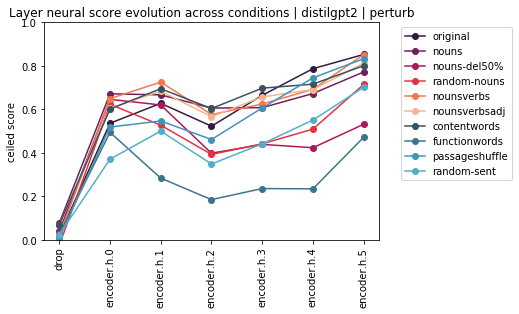

In [8]:
get_layerplot('distilgpt2', scr_perturb="perturb")

# Loop into subplots

In [9]:
import math
from matplotlib.gridspec import GridSpec

def get_lineplots_loop(model_list,scr_perturb=None,error_shading=True):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    #line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    #line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    #if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
        
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle(f'Score evolution of layers over conditions | {scr_perturb}', fontsize=22, y=1.1)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                print(model_list[model_counter])
                layers = get_all_layers(model_list[model_counter])
                score_dict = get_score_dict(model_list[model_counter],scr_perturb=scr_perturb)
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                x = np.array(layers)
                for key,value in score_dict.items():
                    f2_ax[-1].plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
                    if error_shading==True:
                        f2_ax[-1].fill_between(x,np.array(score_dict[key]['score'])-np.array(score_dict[key]['error']), np.array(score_dict[key]['score'])+np.array(score_dict[key]['error']),facecolor=line_colors[counter],alpha=0.05)
                    counter += 1

                conditions = list(score_dict.keys())

                f2_ax[-1].set_title('{}'.format(model_list[model_counter]),fontsize=18)
                f2_ax[-1].yaxis.set_label_text('ceiled score')
                f2_ax[-1].set_ylim([0, 1])
                plt.xticks(rotation= 90)
                #if model_counter == 0:
                    #f2_ax[-1].legend(conditions, loc='lower right')
                model_counter += 1
    #fig2.legend(conditions, loc='lower right')
    fig2.legend(conditions, bbox_to_anchor=(1.05, 1), loc='upper left')
    fig2.savefig(f'fig/{date.today()}_match-to-brain-evolution_error-shading={error_shading}_loop_{scr_perturb}.png', bbox_inches='tight')

distilgpt2
distilgpt2-avgtoken
gpt2
gpt2-avgtoken


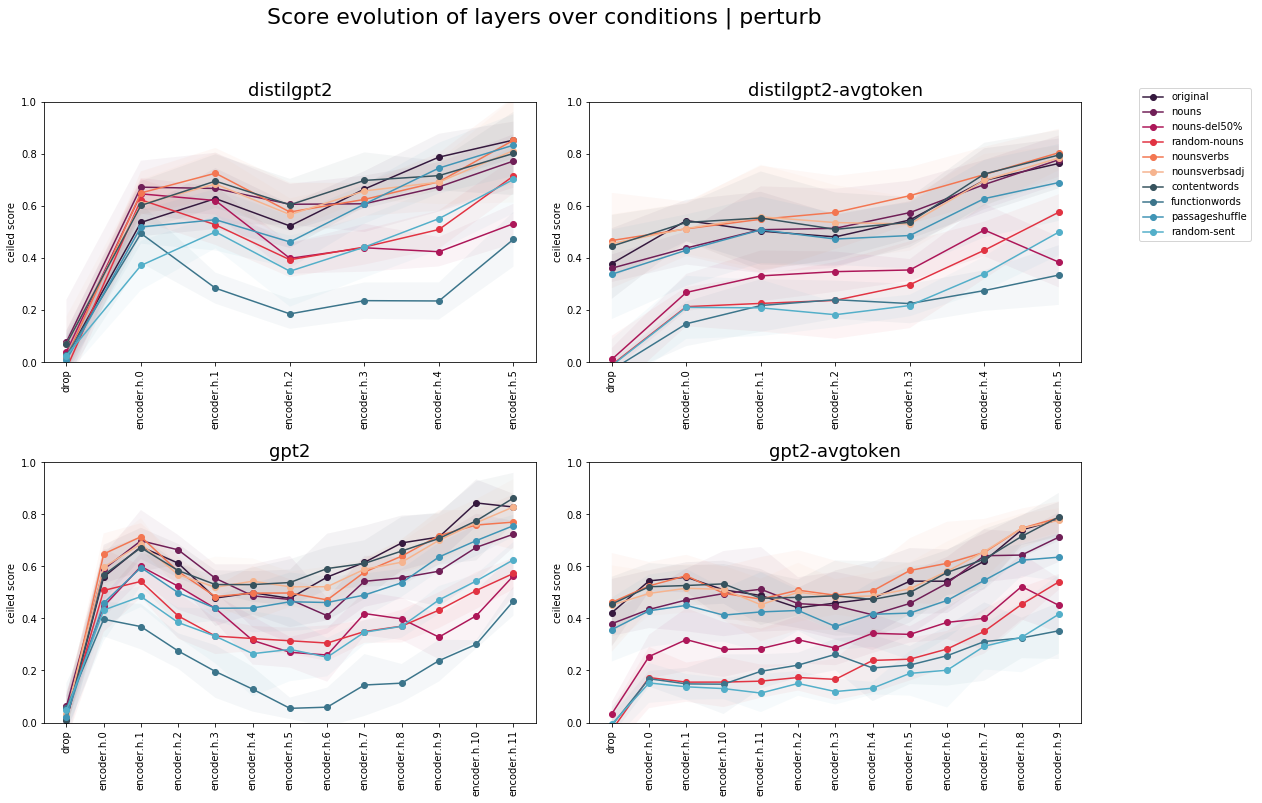

In [10]:
get_lineplots_loop(['distilgpt2', 'distilgpt2-avgtoken', 'gpt2', 'gpt2-avgtoken'],scr_perturb="perturb",error_shading=True)

distilgpt2
distilgpt2-avgtoken
gpt2
gpt2-avgtoken


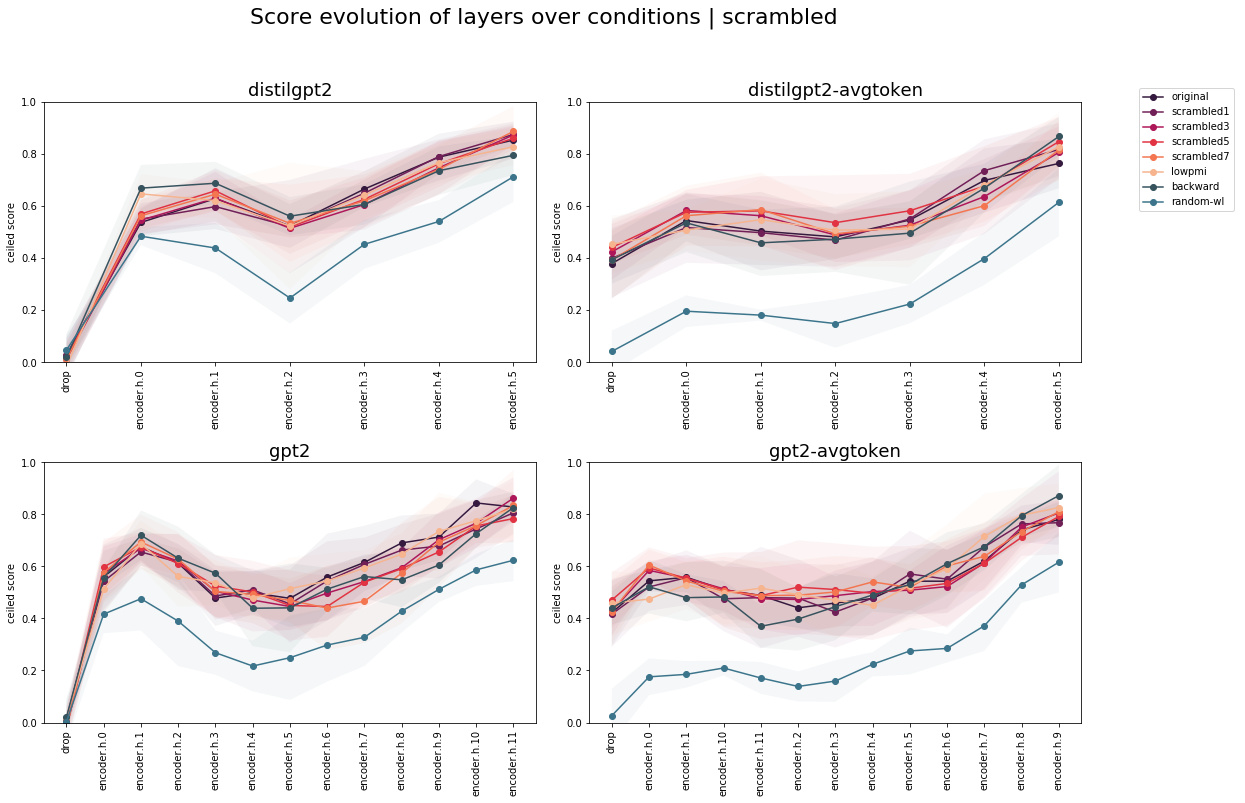

In [11]:
get_lineplots_loop(['distilgpt2', 'distilgpt2-avgtoken', 'gpt2', 'gpt2-avgtoken'],scr_perturb="scrambled",error_shading=True)